In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np
LOG.propagate = False

In [46]:
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2025-03-23 16:19:18,357 | INFO     |: Looking for Artemis Nano Peripheral Device: c0:81:04:26:a3:64
2025-03-23 16:19:21,268 | INFO     |: Connected to c0:81:04:26:a3:64


/Users/akin/Desktop/Desktop/dev/fastrobots/ble_robot_1.2/ble_python/base_ble.py:104: FutureWarning: This method will be removed future version, pass the callback to the BleakClient constructor instead.
  self.client.set_disconnected_callback(self.disconnect_handler)


In [45]:
ble.disconnect()

2025-03-23 16:19:14,371 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [47]:
ble.send_command(CMD.PING, "")

In [48]:
s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [13]:
ble.send_command(CMD.SET_PID_GAINS, "0.08|0.0005|1.0")

In [69]:
ble.send_command(CMD.SET_PID_GAINS, "2.5|0.02|0.7")

In [70]:
ble.send_command(CMD.SET_SETPOINT, "90")

In [71]:
ble.send_command(CMD.START_PID, "")

In [73]:
ble.send_command(CMD.STOP_PID, "")

2025-03-23 16:23:40,184 | INFO     |: Disconnected from A1C0DD95-B611-6CFA-AF80-6BCF50487F59


In [62]:
results = []
# ble.stop_notify(ble.uuid['RX_STRING'])
def notification_handler(uuid, byte_array):
    time, tof, pwm = ble.bytearray_to_string(byte_array).split('|')
    results.append([float(time), float(tof), int(pwm)])

ble.start_notify(ble.uuid['RX_STRING'], notification_handler)
ble.send_command(CMD.SEND_PID_DATA, "")

In [37]:
ble.stop_notify(ble.uuid['RX_STRING'])

In [63]:
print(results)

[[266502.0, -13.0, 255], [266504.0, -13.0, 255], [266511.0, -13.0, 255], [266513.0, -13.0, 255], [266518.0, -13.0, 255], [266520.0, -13.0, 255], [266522.0, -13.0, 255], [266524.0, -13.0, 255], [266526.0, -13.0, 255], [266528.0, -13.0, 255], [266536.0, -13.0, 255], [266538.0, -13.0, 255], [266540.0, -13.0, 255], [266542.0, -13.0, 255], [266544.0, -13.0, 255], [266548.0, -13.0, 255], [266550.0, -13.0, 255], [266552.0, -13.0, 255], [266555.0, -13.0, 255], [266557.0, -13.0, 255], [266559.0, -13.0, 255], [266562.0, -13.0, 255], [266564.0, -13.0, 255], [266566.0, -13.0, 255], [266573.0, -13.0, 255], [266575.0, -13.0, 255], [266577.0, -13.0, 255], [266584.0, -13.0, 255], [266586.0, -13.0, 255], [266593.0, -13.0, 255], [266595.0, -13.0, 255], [266597.0, -13.0, 255], [266601.0, -13.0, 255], [266603.0, -13.0, 255], [266605.0, -13.0, 255], [266609.0, -13.0, 255], [266611.0, -13.0, 255], [266614.0, -13.0, 255], [266616.0, -13.0, 255], [266618.0, -13.0, 255], [266625.0, -13.0, 255], [266627.0, -13.

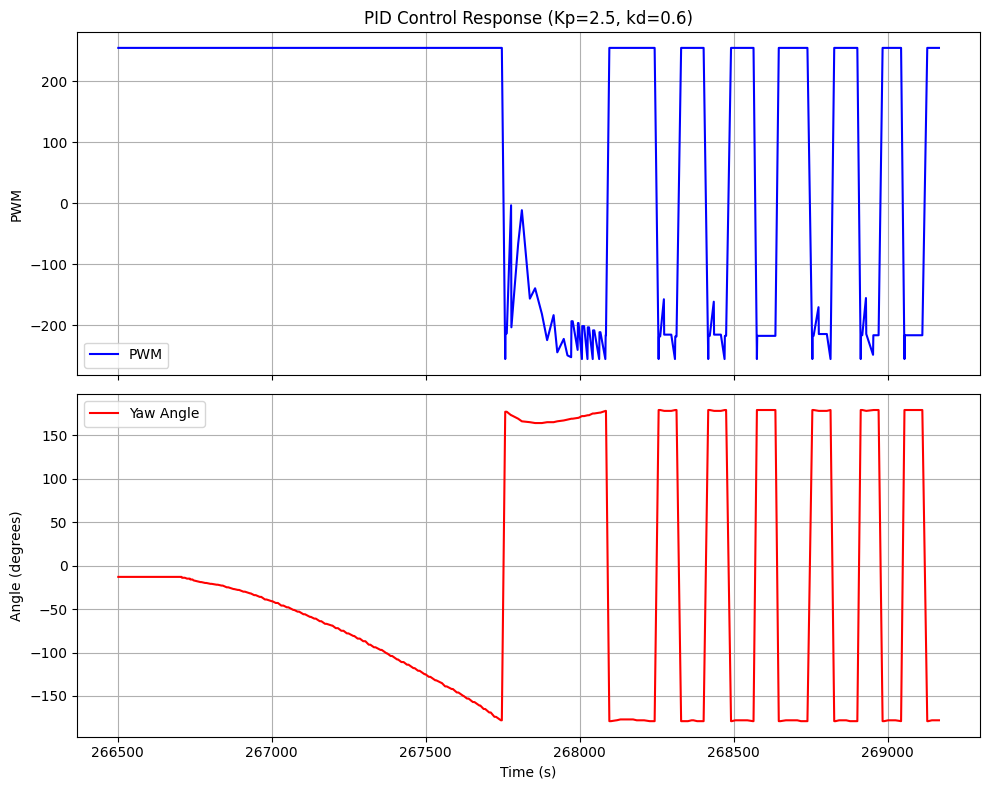

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Convert results to numpy array for easier handling
data = np.array(results)
time = data[:, 0]
tof = data[:, 1]
pwm = data[:, 2]

# Create figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot PWM vs Time
ax1.plot(time, pwm, 'b-', label='PWM')
ax1.set_ylabel('PWM')
ax1.set_title('PID Control Response (Kp=2.5, kd=0.6)')
ax1.grid(True)
ax1.legend()

# Plot ToF vs Time
ax2.plot(time, tof, 'r-', label='Yaw Angle')

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Angle (degrees)')
# Set y-axis ticks in steps of 100
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()